In [172]:
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import *
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from typing import Any, Callable, Dict, List, Tuple, Union, Optional
from functools import wraps
import os
import random
from abc import ABC, abstractmethod
from collections import deque, namedtuple

In [173]:
@dataclass
class EnforceClassTyping:
    def __post_init__(self):
        for (name, field_type) in self.__annotations__.items():
            if not isinstance(self.__dict__[name], field_type):
                current_type = type(self.__dict__[name])
                raise TypeError(f"The field `{name}` was assigned by `{current_type}` instead of `{field_type}`")
        # print("Check is passed successfully")
def EnforceMethodTyping(func: Callable) -> Callable:
    'Enforces type annotation/hints for class mathods'
    arg_annotations = func.__annotations__
    if not arg_annotations:
        return func

    @wraps(func)
    def wrapper(self, *args: Tuple[Any], **kwargs: Dict[str, Any]) -> Any:
        for arg, annotation in zip(args, arg_annotations.values()):
            if not isinstance(arg, annotation):
                raise TypeError(f"Expected {annotation} for argument {arg}, got {type(arg)}.")

        for arg_name, arg_value in kwargs.items():
            if arg_name in arg_annotations:
                annotation = arg_annotations[arg_name]
                if not isinstance(arg_value, annotation):
                    raise TypeError(f"Expected {annotation} for keyword argument {arg_name}, got {type(arg_value)}.")

        return func(self, *args, **kwargs)

    return wrapper
def EnforceFunctionTyping(func: Callable) -> Callable:
    'Enforces type annotation/hints for other functions'
    @wraps(func)
    def wrapper(*args, **kwargs):
        # Check positional arguments
        for arg, annotation in zip(args, func.__annotations__.values()):
            if not isinstance(arg, annotation):
                raise TypeError(f"Expected {annotation} for {arg}, got {type(arg)}.")

        # Check keyword arguments
        for arg_name, arg_value in kwargs.items():
            if arg_name in func.__annotations__:
                annotation = func.__annotations__[arg_name]
                if not isinstance(arg_value, annotation):
                    raise TypeError(f"Expected {annotation} for {arg_name}, got {type(arg_value)}.")

        return func(*args, **kwargs)

    return wrapper
 

In [174]:
@dataclass
class Environment(ABC):  

  class State:
      pass
  InitialState: State 
  CurrentState: State 

  @abstractmethod
  def TransitionModel(self, State: State, Action)-> State:
      ...

  @abstractmethod
  def RewardModel(self, State: State, Action, NextState: State, TerminalSignal: bool)-> float:
      ...

  @abstractmethod
  def IsTerminalCondition(self, State: State)-> bool:
      ...

  @abstractmethod
  def StateTransition(self, State: State, Action)-> tuple[float, State, bool]:
      ...

  @abstractmethod
  def SampleTrajectory(self, RunDuration: float, Policy: Optional[Callable])-> list[State]:
      ...

In [175]:
# @dataclass
# class MPController(ABC):
#   EnvironmentModel: Environment
#   InternalModel: Callable
#   Policy: Callable

#   @abstractmethod
#   def Act(self, Observation: T.Tensor)-> T.Tensor:
#       'Produces an action based on the observation of the current state of the environment'
#       ...
#   @abstractmethod
#   def Plan(self)-> tuple[list[EnvironmentModel.State], list[T.Tensor]]:
#       'Produces an sequence of actions and predicted states based on the observation of the current state of the environment'
#       ...
#   @abstractmethod
#   def Observe(self)-> T.Tensor:
#       'Produces a vector encoding the observable information of the observation of the current state of the environment'
#       ... 
#   @abstractmethod
#   def Learn(self):
#       'Improves the agent by updating its models'
#       ...  
#   @abstractmethod
#   def LearningAlgorithm(self):
#       ...


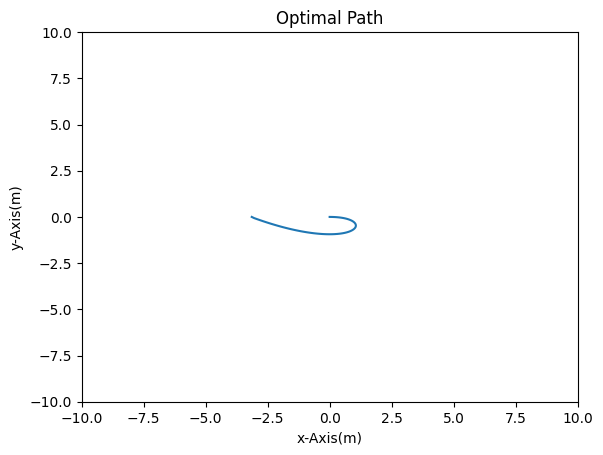

In [176]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

@dataclass
class Particle(EnforceClassTyping):
    'This class represents the electric field sources with its position in the field(Position) and the magnitude of the source(Charge)'
    Mass: float # kg
    Charge: float #C
from torch import Tensor

@dataclass
class Field(ABC):
  @abstractmethod
  def FieldStrength(self, ObservationPosition: T.Tensor)-> T.Tensor:
    ...
  @abstractmethod
  def FieldPotential(self, ObservationPosition: T.Tensor)-> float:
    ...
  def PotentialDifference(self, InitialPosition: T.Tensor, FinalPosition: T.Tensor) -> float:
    ...

@dataclass(kw_only= True)
class ElectricField(Field):
  FieldSources: Dict

  def __call__(self, ObservationPosition: T.Tensor)->T.Tensor:
      return self.FieldStrength(ObservationPosition)
  @EnforceMethodTyping
  def FieldStrength(self, ObservationPosition: T.Tensor)->T.Tensor:
    'This function takes a list of sources and outputs the field strength experienced at any given point(s). This determines the physics of the field(an electric field in this case)'
    CoulombConstant = 8.9875e9 #N*m^2/C^2
    assert len(self.FieldSources["Particle"]) == len(self.FieldSources["Position"]), "The length of particles and fields don't match"
    for FieldSource, _ in zip(self.FieldSources["Particle"], self.FieldSources["Position"]):
      assert isinstance(FieldSource, Particle),  "The FieldSource is not a Particle"
    ElectricFieldVector = T.zeros_like(ObservationPosition)
    for FieldSource, SourcePosition in zip(self.FieldSources["Particle"], self.FieldSources["Position"]):
      PositionMatrices= T.stack([T.ones_like(ObservationPosition[0])* SourcePosition[0].item(), 
                                T.ones_like(ObservationPosition[1])* SourcePosition[1].item()])
      DisplacementVector = ObservationPosition - PositionMatrices
      DisplacementMagnitude = T.sqrt(DisplacementVector[0]**2 +DisplacementVector[1]**2)
      ElectricFieldVector += (DisplacementVector * FieldSource.Charge) / DisplacementMagnitude**2
    return CoulombConstant * ElectricFieldVector #N/C or V/m
  @EnforceMethodTyping
  def FieldPotential(self, InitialPosition: T.Tensor, FinalPosition: T.Tensor, resolution: int= 5000)-> float:
      '''This method determines the amount of work required to get one position to another in the field'''
      XInterval= (FinalPosition[0] - InitialPosition[0]) / resolution
      YInterval= (FinalPosition[1] - InitialPosition[1]) / resolution
      XPositions = [InitialPosition[0] + i * XInterval for i in range(resolution + 1)]
      YPositions = [InitialPosition[1] + i * YInterval for i in range(resolution + 1)]
      WorkDone = 0
      for i in range(resolution):
          PositionFieldStrength = self.FieldStrength(T.Tensor([XPositions[i], YPositions[i]]))
          WorkDone += - (PositionFieldStrength[0]*XInterval + PositionFieldStrength[1]*YInterval)
      return WorkDone
  @EnforceMethodTyping
  def PlotField(self):
      'This funtion plots the 2D electric vector field'
      ObservationPosition= T.meshgrid(T.linspace(self.FieldLowBound, self.FieldHighBound, 50), 
                                      T.linspace(self.FieldLowBound, self.FieldHighBound, 50))
      ObservationPosition= T.stack(ObservationPosition)
      xd, yd = self.ElectricFieldStrength(ObservationPosition)
      xd = xd / T.sqrt(xd**2 + yd**2)
      yd = yd / T.sqrt(xd**2 + yd**2)
      color_aara = T.sqrt(xd**2+ yd**2)
      fig, ax = plt.subplots(1,1)
      cp = ax.quiver(ObservationPosition[0],ObservationPosition[1],xd,yd,color_aara)
      fig.colorbar(cp)
      plt.rcParams['figure.dpi'] = 250
      plt.show()
  def Derivative(self, ObservationPosition):
    'This function returns the derivative of the field at a given point'
    CoulombConstant = 8.9875e9 #N*m^2/C^2
    assert len(self.FieldSources["Particle"]) == len(self.FieldSources["Position"]), "The length of particles and fields don't match"
    for FieldSource, _ in zip(self.FieldSources["Particle"], self.FieldSources["Position"]):
      assert isinstance(FieldSource, Particle),  "The FieldSource is not a Particle"
    ElectricFieldVector = T.zeros_like(ObservationPosition)
    for FieldSource, SourcePosition in zip(self.FieldSources["Particle"], self.FieldSources["Position"]):
      PositionMatrices= T.stack([T.ones_like(ObservationPosition[0])* SourcePosition[0].item(), 
                                T.ones_like(ObservationPosition[1])* SourcePosition[1].item()])
      DisplacementVector = ObservationPosition - PositionMatrices
      DisplacementMagnitude = T.sqrt(DisplacementVector[0]**2 +DisplacementVector[1]**2)
      ElectricFieldVector += (DisplacementVector * FieldSource.Charge) / DisplacementMagnitude**1.5
    return -CoulombConstant * ElectricFieldVector

NegativeCharge= Particle(Mass=1.0, Charge= -1e-6)
PositiveCharge= Particle(Mass=1.0, Charge= 1e-6)
Sources = {"Particle": [NegativeCharge],
          "Position": [T.tensor([1.0, 0.0])]}

TestElectricField= ElectricField(FieldSources=Sources)

# Time discretization
N = 100    # number of time steps
t_f = 2.0  # final time (s)
dt = t_f / (N - 1)

# System dynamics
def dynamics(State, Time, ControlForce):
  dxPosition, dyPosition = State[2], State[3]
  Position= T.tensor([State[0], State[1]])
  dxVelocity, dyVelocity = ((PositiveCharge.Charge* TestElectricField(Position))+ControlForce)/PositiveCharge.Mass

  return np.array([dxPosition, dyPosition, dxVelocity, dyVelocity])

# Objective function
def objective(z):
    px = T.tensor([z[:N]])
    vx = z[N:2*N]
    py = T.tensor([z[2*N:3*N]])
    vy = z[3*N:4*N]
    u1 = z[4*N:5*N]
    u2 = z[5*N:]
    Pos= T.transpose(T.cat([px, py], 0), 0, 1)
    
    EField= [T.norm(TestElectricField(i)) for i in Pos]
    # print(sum(EField))
    return np.sum(u1**2+ u2**2) * dt

# Constraints
def constraints(z):
  x = z[:4*N].reshape((-1, 4))
  u1 = z[4*N:5*N]
  u2 = z[5*N:]
  ceq = []
  
  # Dynamics constraints
  for k in range(N-1):
    x_k = x[k]
    x_kp1 = x[k+1]
    u1_k = u1[k]
    u2_k = u2[k]
    f_k = dynamics(x_k, 1.0, T.tensor([u1_k, u2_k]))
    f_kp1 = dynamics(x_kp1, 1.0, T.tensor([u1[k+1], u2[k+1]]))
    ceq.extend((x_kp1 - x_k) - (dt * (f_k + f_kp1))/2)
  
  # Boundary conditions
  ceq.extend([x[0, 0], x[0, 1], x[0, 2] + np.pi, x[0, 3]])  # Initial state
  ceq.extend([x[-1, 0], x[-1, 1], x[-1, 2], x[-1, 3]])      # Final state
  
  return np.array(ceq)

# Initial guess
x0 = np.zeros(6*N)
x0[:N] = np.linspace(0, 0, N)  # xPosition
x0[N:2*N] = np.linspace(0, 0, N)  # xVelocity
x0[2*N:3*N] = np.linspace(np.pi, 0, N)  # yPosition
x0[3*N:4*N] = np.linspace(0, 0, N)  # yVelocity

# Solve the optimization problem
res = minimize(objective, x0, method='SLSQP', constraints={'type': 'eq', 'fun': constraints})

# Extract the optimal trajectory
x_opt = res.x[:4*N].reshape((-1, 4))
u1_opt = res.x[4*N:5*N]
u2_opt = res.x[5*N:]
# Plot the results
t = np.linspace(0, t_f, N)

plt.plot(x_opt[:, 2], x_opt[:, 0])
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.title('Optimal Path')
plt.xlabel('x-Axis(m)')
plt.ylabel('y-Axis(m)')

plt.show()